# Machine Learning I, Programming Exercise 5
You will probably find that the tasks in this notebook are considerably more difficult than those in the previous exercises. That is because it will examine new concepts that are only touched upon briefly in the lecture. If you get stuck at some point or find that the task descriptions are unclear, please ask your questions in the "Exercise Questions" channel of the Mattermost and tag it with `@tmichels` so that I will be notified. 

## 1. PyTorch
Now that the lecture is starting to focus on neural networks, we will start working with *PyTorch*, as it offers a great variety of features making the handling of neural networks much more convenient. In theory, we could also use Scikit-Learn or even code the NN from scratch in Numpy, but there are a few advantages that make PyTorch a better suited choice for our tasks:
* Fast implementations for the most common layer types (fully-connected, convolution, etc.) are available.
* GPU support (only for NVIDIA cards, though)
* Automatic differentiation (AD) engine that can compute the gradient of (almost) any function automatically

Installing the library is again quite simple. Visit [this link](https://pytorch.org/get-started/locally/) and adjust the command in the following cell according to your needs. We will try to keep the computational effort for the exercises in reasonable bounds, so GPU support is not needed but you can install it if you want. Just make sure that the CUDA version you select supports your NVIDIA GPU.

In [1]:
import sys

# Installation using conda and no gpu support
!conda install --yes --prefix {sys.prefix} pytorch torchvision cpuonly -c pytorch
# Alternatively, the command for using pip would look like this:
# !{sys.executable} -m pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Solving environment: done

# All requested packages already installed.



PyTorch's low-level API is quite similar to Numpy's, except for fact that the fundamental datatype is called `tensor` instead of `ndarray`. In fact, most functions and attributes (e.g., `dot()`, `shape`, `squeeze()`, etc.) have the same names and functionality. Hence, it should not be too difficult for you to get accustomed to PyTorch.

1. Read the first two parts of the [PyTorch Blitz Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). The first part deals with the basic low-level API, while the second introduces the `Autograd` AD engine. This should give you a rough idea of what PyTorch can and cannot do.
2. Remember Himmelblau's function from programming exercise 2? Compute its gradient at several randomly chosen points using only PyTorch's `Autograd` engine. Compare the values with the analytically derived function `himmelblau_gradient` from exercise 2.
3. Implement a function `auto_hessian` that computes the Hessian matrix of another arbitrary function in a specified point. It should take the following arguments:
    * `func`: A python function that takes a single one-dimensional `tensor` as its argument and outputs a scalar `tensor`. All computatons inside the function should be performed with PyTorch.
    * `x`: The point in which to evaluate the Hessian.
Test your implementation on Himmelblau's function using the analytically derived `himmelblau_hessian`.

   **Hint:** "The Hessian matrix of a function $f$ is the Jacobian matrix of the gradient of the function: $\mathbf{H}(f(\mathbf{x})) = \mathbf{J}(\nabla f(\mathbf{x}))$" (see [Wikipedia](https://en.wikipedia.org/wiki/Hessian_matrix)). Also take a look at PyTorch's [`torch.autograd.grad`](https://pytorch.org/docs/master/autograd.html#torch.autograd.grad) function.

In [2]:
import torch

def himmelblau_wrapper(func):
    """
    This decorator allows passing one array containing [x,y]
    to the functions instead of both parameters separately
    """
    def wrapper(x):
        return func(*x)
    
    return wrapper

@himmelblau_wrapper
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

@himmelblau_wrapper
def himmelblau_gradient(x, y):
    x_bar = 4*x*(x**2 + y - 11) + 2*(x + y**2 - 7)
    y_bar = 2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)
    return torch.tensor([x_bar, y_bar])

@himmelblau_wrapper
def himmelblau_hessian(x, y):
    xx_bar = 4*(x**2 + y - 11) + 8*x**2 + 2
    yy_bar = 2 + 4*(x + y**2 - 7) + 8*y**2
    xy_bar = 4*x + 4*y
    return torch.tensor([[xx_bar, xy_bar], [xy_bar, yy_bar]])


def auto_gradient(func, x):
    assert x.ndim == 1
    x = x.clone().detach().requires_grad_(True)
    
    return torch.autograd.grad([func(x)], [x])[0]

def auto_hessian(func, x):
    assert x.ndim == 1
    d = x.shape[0]
    bar = torch.zeros_like(x)
    x = x.clone().detach().requires_grad_(True)
    
    hessian = torch.empty(size=(d, d), dtype=x.dtype, device=x.device)
    for i in range(d):
        # Compute one row of the Hessian at a time
        grad = torch.autograd.grad([func(x)], [x], create_graph=True)[0]
        bar[i] = 1
        hessian_row = torch.autograd.grad([grad], [x], [bar])
        hessian[i] = hessian_row[0].data
        bar[i] = 0
    
    return hessian


x = torch.rand(2)

g_auto = auto_gradient(himmelblau, x)
print('Gradient calculated by Autograd:')
print(g_auto)
g_hand = himmelblau_gradient(x)
print('Gradient calculated by hand:')
print(g_hand)
assert torch.all(g_auto == g_hand)

h_auto = auto_hessian(himmelblau, x)
print('Hessian calculated by Autograd:')
print(h_auto)
h_hand = himmelblau_hessian(x)
print('Hessian calculated by hand:')
print(h_hand)
assert torch.all(h_auto == h_hand)

Gradient calculated by Autograd:
tensor([-37.1402, -24.7649])
Gradient calculated by hand:
tensor([-37.1402, -24.7649])
Hessian calculated by Autograd:
tensor([[-37.4033,   2.8956],
        [  2.8956, -23.4323]])
Hessian calculated by hand:
tensor([[-37.4033,   2.8956],
        [  2.8956, -23.4323]])


## 2. Convolution
The *convolution* operation is of central importance for many modern neural network architectures, especially when it comes to processing images. Before we delve into details, it is a good idea to gain some insights into the fundamentals.

Mathematically speaking, we define the convolution of two *discrete* functions $f, g: \mathbb{Z} \to \mathbb{R}$ in the following way:
\begin{equation*}
    (f * g)(x) = \sum_{k=-\infty}^{\infty} f(k)g(x-k)
\end{equation*}
For the definiton to make sense, the infinite sum should converge, otherwise the convolution of $f$ and $g$ is not defined in $x$. Note that this definiton also works if $f$ and $g$ are finite sequences: We can simply set all other values to 0, which makes the summation above finite and therefore computable. The operation itself also has a number of useful algebraic properties, which can be easily proven using the definition above:
* *Commutativity*: $(f*g) = (g*f)$, which means that we can switch filter and signal.
* *Associativity*: $(f*g)*h = f*(g*h)$
* *Distributivity*: $f*(g+h) = (f*g) + (f*h)$
* *Scalar multiplication*: $(\lambda f) * g = \lambda (f * g)$ for $\lambda \in \mathbb{R}$

We can extend the definition to multiple input dimensions, i.e., functions $f, g: \mathbb{Z}^n \to \mathbb{R}$ in a straightforward manner:
\begin{equation*}
    (f*g)(x_1, \ldots, x_n) = \sum_{k_1, \ldots, k_n=-\infty}^{\infty} f(k_1, \ldots, k_n)g(x_1-k_1, \ldots, x_n-k_n)
\end{equation*}

But for now, we'll stick with the one-dimensional case to keep things as simple as possible. Consider the sequences `f=[1, 2]` and `g=[8, 3, 19, 13, 12, 14]`, which we can embed into functions $f, g: \mathbb{Z} \to \mathbb{R}$ as follows:
\begin{equation*}
    f(0)=1, f(1)=2 \text{ and } f(z)=0 \text{ for all } z \in \mathbb{Z} \setminus \{0,1\}
\end{equation*}
and
\begin{equation*}
    g(0)=8, g(1)=3, g(2)=19, g(3)=13, g(4)=12, g(5)=14 \text{ and } g(z)=0 \text{ for all } z \in \mathbb{Z} \setminus \{0,\ldots,5\}.
\end{equation*}
Now compute and note, on a sheet of paper or in your head, the convolution $f*g$ according to the definiton above. Since both $f$ and $g$ have finite support, we should also be able to compute this result on a computer. In fact, PyTorch offers the function [`torch.nn.functional.conv1d`](https://pytorch.org/docs/stable/nn.functional.html#conv1d) for cases like this. Don't let the documentation confuse you for now, we will learn what each of the parameters do later in the exercise. Let's just throw the function at our example instead:

In [3]:
import torch
f = torch.tensor([1, 2]).reshape(1, 1, -1)
g = torch.tensor([8, 3, 19, 13, 12, 14]).reshape(1, 1, -1)
res = torch.nn.functional.conv1d(g, f)
print(res)

tensor([[[14, 41, 45, 37, 40]]])


Well, this is definitely not what we would have expected! Upon closer inspection of the result, we can deduce that PyTorch has computed something like a sliding dot product, where the *filter* $f$ is sliding along the *signal* $g$, but that does *not* correspond to the definition of a convolution. In fact, the name of the PyTorch function is quite misleading, as it does not compute the convolution of $f$ and $g$, but another operation called *cross-correlation* instead. For discrete functions $f, g: \mathbb{Z} \to \mathbb{R}$ this operation is defined as
\begin{equation*}
    (f \star g)(x) = \sum_{k=-\infty}^{\infty} f(k)g(x+k)
\end{equation*}
and from this definiton it is immediately clear that $f*g = \tilde{f} \star g$ with $\tilde{f}(x) = f(-x)$. In other words, we have to flip the filter tensor before we pass it to the `conv1d` function.

However, there is another discrepancy between theory and practice in the way how boundary cases are handeled. In order to embed the finite sequences into functions that are defined over all of $\mathbb{Z}$, we added an infinite amount of zeros to both sides of the sequence, but the PyTorch implementation does not consider such a step by default. Instead, we have to manually pad the sequence using the `padding` parameter of the `conv1d` function. Setting `padding=m` means that $m$ zeros are added to both sides of the given input tensor (`g` in our example). If our filter $f$ is finite and has size $l$, we need to pad with least $l-1$ zeros to achieve the result that we would expect from the mathematical definition.

If we make said changes to the code above, we finally get the expected result:

In [4]:
f_rev = torch.flip(f, dims=[-1])
res = torch.nn.functional.conv1d(g, f_rev, padding=1)
print(res)

tensor([[[ 8, 19, 25, 51, 38, 38, 28]]])


Now that we have a basic understanding of what the "convolution" functions in PyTorch actually do, we can switch our focus to images and hence we will use [`conv2d`](https://pytorch.org/docs/stable/nn.functional.html#conv2d) from now on. In order to understand what the parameters of ths function mean, please read the documentation carefully and also take a look at [this link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md). It shows a collection of animated figures, each visualizing a different setting for the parameters. 

1. You have probably noticed that applying a convolution filter to an input changes the spatial size of the output. Take a close look at the documentation for the [`Convolution2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layer to understand how the paramters influence the output size. Often, one does not want to change the spatial size during the convolution, which means that padding must be used. Your job is to write a function that calculates the required amount of padding, s.t. the output of a convoluton has the same size as the original input. More specifically, it should accept the following arguments:
    * `kernel_size`: An integer or 2-tuple (height, width) that specifies the spatial dimensions of the filter (also called kernel).
    * `input_size`: An integer or 2-tuple (height, width) that specifies the spatial dimensions of the input image.
    * `stride`: An integer or 2-tuple (vertical, horizontal) that specifies the striding of the convolution operation.
    * `dilation`: An integer or 2-tuple (vertical, horizontal) that specifies the dilation rate for the filter.
    
   Finally, return a 4-tuple `(pad_left, pad_right, pad_top, pad_bottom)` that specifies the required amount of padding on each side of the image. It should be possible to pass those values to the [`pad`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad) function.

In [5]:
import torch

def calc_same_pad2d(in_shape, kernel_size, stride=1, dilation=1):
    in_shape = torch.nn.modules.utils._pair(in_shape)
    kernel_size = torch.nn.modules.utils._pair(kernel_size)
    stride = torch.nn.modules.utils._pair(stride)
    dilation = torch.nn.modules.utils._pair(dilation)

    # Horizontal
    total_pad = in_shape[1] * (stride[1] - 1) - stride[1] + dilation[1] * (kernel_size[1] - 1) + 1
    pad_left = (total_pad+1) // 2
    pad_right = total_pad - pad_left

    # Vertical
    total_pad = in_shape[0]*(stride[0]-1) - stride[0] + dilation[0]*(kernel_size[0]-1) + 1
    pad_top = (total_pad+1) // 2
    pad_bottom = total_pad - pad_top

    return pad_left, pad_right, pad_top, pad_bottom


kernel_size = tuple(torch.randint(1, 6, size=(2,)).numpy())
image_size = tuple(torch.randint(20, 256, size=(2,)).numpy())
stride = torch.randint(1, 4, size=(1,)).item()
dilation = torch.randint(1, 3, size=(1,)).item()

# PyTorch's image format is (B, C, H, W), where C is the number of color channels (usually 3)
# and H, W are the height and width of the image, respectively.
# B is called the batch_size and it is simply an extra dimension that allows us to concatenate
# several images and process them in parallel.
image = torch.rand((1,3)+image_size)
# The kernel tensor has shape (K, C', KH, HW), where K is the number of filters that should
# be processed in parallel, C' is the number of input channels (usually C'=C) and
# KH, KW are the height and width of the filter, respectively.
kernel = torch.rand((1, 3)+kernel_size)

print('Parameters:')
print('Image size:', image_size)
print('Kernel size:', kernel_size)
print('Stride:', stride)
print('Dilation:', dilation)

padding = calc_same_pad2d(image_size, kernel_size, stride, dilation)
print('Calculated Padding:', padding)
pad_img = torch.nn.functional.pad(image, padding, mode='constant')
print('Padded image size:', pad_img.shape[-2:])

res_img = torch.nn.functional.conv2d(pad_img, kernel, stride=stride, dilation=dilation)
print('Conv. output size:', res_img.shape[-2:])
assert image_size == res_img.shape[-2:]

Parameters:
Image size: (241, 66)
Kernel size: (2, 5)
Stride: 1
Dilation: 1
Calculated Padding: (2, 2, 1, 0)
Padded image size: torch.Size([242, 70])
Conv. output size: torch.Size([241, 66])


2. In the lecture, you have heard about *pooling* operations. Generally speaking, they subdivide the image into non-overlapping patches of the same size and apply an aggregation function on each patch separately. It turns out that *average pooling*, i.e., the aggregation function is simply the average of each patch, can be represented by a convolution. Your task is to implement avg. pooling with an arbitrary patch size of $(h, w)$ using the `conv2d` function. That means you'll have to come up with the correct set of parameters that need to be passed to the function. Compare your results with what is output by the [`avg_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#avg-pool2d) function.

In [6]:
import torch

def my_avg_pool2d(input, kernel_size, padding=0):
    assert input.ndim == 4
    kernel_size = torch.nn.modules.utils._pair(kernel_size)
    kernel_elements = kernel_size[0]*kernel_size[1]
    channels = input.shape[1]
    
    kernel_shape = (channels, 1) + kernel_size
    kernel = torch.full(kernel_shape, 1/kernel_elements, dtype=input.dtype, device=input.device)
    return torch.nn.functional.conv2d(input, kernel, stride=kernel_size, padding=padding, groups=channels)


img = torch.randint(10, size=(3, 8, 8)).to(torch.get_default_dtype()).unsqueeze(0)
print('The orginal image:')
print(img)
my_pool_img = my_avg_pool2d(img, 2)
print('Custom avg. pooling result:')
print(my_pool_img)
pool_img = torch.nn.functional.avg_pool2d(img, 2)
print('PyTorch avg. pooling result:')
print(pool_img)
assert torch.all(my_pool_img == pool_img)

The orginal image:
tensor([[[[4., 0., 6., 4., 7., 5., 0., 6.],
          [6., 6., 3., 5., 6., 0., 2., 4.],
          [4., 0., 4., 7., 1., 8., 5., 4.],
          [4., 1., 7., 5., 8., 3., 8., 9.],
          [6., 1., 9., 5., 0., 7., 2., 2.],
          [8., 2., 2., 7., 0., 8., 4., 2.],
          [0., 4., 7., 8., 3., 1., 3., 9.],
          [2., 0., 5., 1., 1., 1., 2., 1.]],

         [[2., 7., 5., 8., 7., 3., 7., 4.],
          [1., 9., 9., 1., 6., 6., 2., 0.],
          [5., 1., 3., 0., 3., 1., 7., 2.],
          [4., 6., 1., 2., 2., 7., 5., 2.],
          [1., 2., 4., 3., 6., 2., 9., 2.],
          [9., 0., 1., 6., 9., 5., 4., 7.],
          [3., 5., 3., 4., 4., 1., 3., 6.],
          [9., 9., 0., 2., 1., 6., 9., 1.]],

         [[3., 3., 7., 0., 7., 7., 5., 3.],
          [8., 8., 8., 8., 3., 1., 2., 9.],
          [6., 1., 8., 4., 7., 3., 1., 9.],
          [5., 7., 9., 9., 5., 5., 8., 8.],
          [6., 6., 5., 1., 9., 3., 8., 5.],
          [2., 3., 4., 7., 9., 5., 2., 2.],
         

3. One of the most widely used filters in digital signal processing and also image processing is the Gaussian blur. The name comes from the fact that it approximates the probability density function of Gaussian random variable with mean $0$ and variance $\sigma^2 > 0$:
\begin{equation*}
    f_{\sigma}(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{x^2}{2\sigma^2}\right)
\end{equation*}
Strictly speaking, the function is positive everywhere, which would mean that a discrete filter representing it must be infinitely large. To keep things feasible, all values that have a distance larger than $c\sigma$ ($c>0$, usually $c=3$) to the center at $0$ are usually truncated and set to $0$. That means the size of the discrete filter is determined by $\sigma$ and it will look like this:
\begin{equation*}
    \left[f_{\sigma}(-\lceil c\sigma \rceil), \ldots, f_{\sigma}(-1), f_{\sigma}(0), f_{\sigma}(1), \ldots, f_{\sigma}(\lceil c\sigma \rceil)\right]
\end{equation*}
In general, the elements of this sequence will not add up to 1, but this can be fixed by simply dividing them by their sum.

   Since we are working with images and therefore two-dimensional signals, we might want to consider the case of a Gaussian random variable with mean $\mathbf{0}$ and covariance matrix $\sigma^2 I$ instead:
\begin{equation*}
    f(x, y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
\end{equation*}
The discrete approximation works analogously to the one-dimensional case.

   Consider the following tasks:
    * Implement a function that takes $\sigma$ and $c$ as arguments and returns the discrete approximation to the one-dimensional Gaussian probability density function as a PyTorch tensor. Make sure that the elements of the returned `tensor` sum up to 1.
    * Repeat the previous assignment for the 2D case and apply the resulting filter to the test image given in the code skeleton for a few values of $\sigma$. Use your function from part 1 to ensure that the output image has the same size as the input.
    * Let $\mathbf{g} \in \mathbb{R}^d$ be an approximation to a Gauss filter with variance $\sigma^2$. We can also interpret $\mathbf{g}$ as an image $I_g$ of size $d \times 1$ and at the same time as a 2D filter $f_g$ of size $1 \times d$. Compute the convolution $f_g * I_g$ with appropriate zero padding ($d-1$ horizontally on both sides) and compare the result to the 2D filter obtained in the previous part.
    * Given the results from the last part and recalling the algebraic properties of the convolution operation, can you think of a way to speed up the 2D Gaussian blur for larger kernel sizes?

1D Gaussian filter with sigma=0.25:
tensor([3.3524e-04, 9.9933e-01, 3.3524e-04]) , sum: 1.0
2D Gaussian filter with sigma=0.25:
tensor([[1.1238e-07, 3.3501e-04, 1.1238e-07],
        [3.3501e-04, 9.9866e-01, 3.3501e-04],
        [1.1238e-07, 3.3501e-04, 1.1238e-07]]) , sum: 1.0
2D filter computed as the outer product of two 1D Gaussan filters with sigma=0.25:
tensor([[1.1238e-07, 3.3501e-04, 1.1238e-07],
        [3.3501e-04, 9.9866e-01, 3.3501e-04],
        [1.1238e-07, 3.3501e-04, 1.1238e-07]]) , sum: 1.0000001192092896
2D filter computed as the convolution of two 1D Gaussan filters with sigma=0.25:
tensor([[[[1.1238e-07, 3.3501e-04, 1.1238e-07],
          [3.3501e-04, 9.9866e-01, 3.3501e-04],
          [1.1238e-07, 3.3501e-04, 1.1238e-07]]]]) , sum: 1.0000001192092896
Slow function took 0.5673 seconds.
Fast function took 0.0348 seconds.


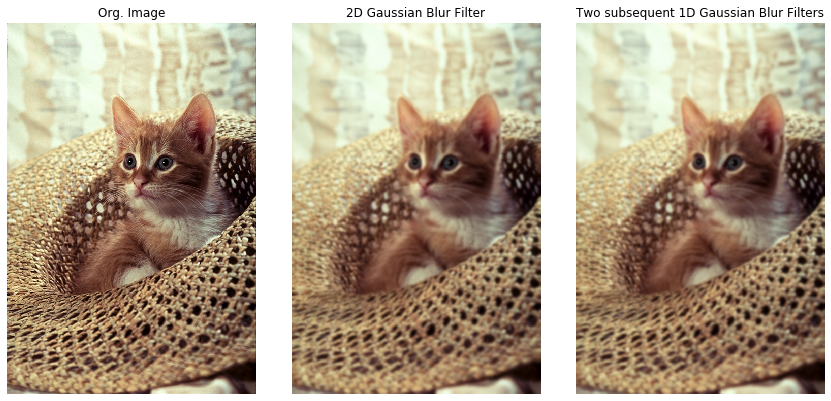

In [10]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
from urllib.request import urlopen

def gaussian_filter1d(sigma, cutoff=3):
    size = int(cutoff*sigma + 0.5)
    x = torch.arange(-size, size+1, dtype=torch.get_default_dtype())
    torch.pow(x, 2, out=x)
    torch.mul(x, -0.5/(sigma**2), out=x)
    torch.exp(x, out=x)
    x /= x.sum()
    return x

def gaussian_filter2d(sigma, cutoff=3):
    size = int(cutoff*sigma + 0.5)
    x = torch.arange(-size, size+1, dtype=torch.get_default_dtype()).reshape(-1, 1)
    y = torch.arange(-size, size+1, dtype=torch.get_default_dtype()).reshape(1, -1)
    torch.pow(x, 2, out=x)
    torch.pow(y, 2, out=y)
    xy = x + y
    torch.mul(xy, -0.5/(sigma**2), out=xy)
    torch.exp(xy, out=xy)
    xy /= xy.sum()
    return xy

def gaussian_blur_slow(input, sigma):
    assert input.ndim == 4
    
    channels = input.shape[1]
    kernel = gaussian_filter2d(sigma)
    kernel_size = kernel.shape
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    kernel = kernel.expand(channels, 1, -1, -1)
    
    padding = calc_same_pad2d(input.shape[-2:], kernel_size)
    input = torch.nn.functional.pad(input, padding, mode='reflect')
    
    return torch.nn.functional.conv2d(input, kernel, groups=channels)

def gaussian_blur_fast(input, sigma):
    assert input.ndim == 4
    
    channels = input.shape[1]
    kernel = gaussian_filter1d(sigma)
    kernel_size = kernel.shape[0]
    
    padding = calc_same_pad2d(input.shape[-2:], (kernel_size, kernel_size))
    input = torch.nn.functional.pad(input, padding, mode='reflect')
    
    # Horizontal
    kernel = kernel.reshape(1, 1, 1, -1)
    kernel = kernel.expand(channels, 1, 1, -1)  
    input = torch.nn.functional.conv2d(input, kernel, groups=channels)
    
    # Vertical
    kernel = kernel.reshape(channels, 1, -1, 1)   
    return torch.nn.functional.conv2d(input, kernel, groups=channels)


def plot_image(ax, image):
    image = image.squeeze(0)
    image = to_pil_image(image)
    ax.set_axis_off()
    ax.imshow(image)

sigma = 0.25
test1d = gaussian_filter1d(sigma)
test2d = gaussian_filter2d(sigma)
testprod = torch.matmul(test1d.reshape(-1,1), test1d.reshape(1,-1))
testconv = torch.nn.functional.conv2d(test1d.reshape(1,1,-1,1), test1d.reshape(1,1,1,-1), 
                                      padding=(0, test1d.shape[0]-1))

print(f'1D Gaussian filter with sigma={sigma}:')
print(test1d, ', sum:', test1d.sum().item())
print(f'2D Gaussian filter with sigma={sigma}:')
print(test2d, ', sum:', test2d.sum().item())
print(f'2D filter computed as the outer product of two 1D Gaussan filters with sigma={sigma}:')
print(testprod, ', sum:', testprod.sum().item())
print(f'2D filter computed as the convolution of two 1D Gaussan filters with sigma={sigma}:')
print(testconv, ', sum:', testconv.sum().item())
assert torch.allclose(test2d, testprod)
assert torch.allclose(test2d, testconv)

# Download a test image
with urlopen('https://homepages.cae.wisc.edu/~ece533/images/cat.png') as f:
    test_img = Image.open(f)
test_img = to_tensor(test_img)
test_img = test_img.unsqueeze(0)

# Apply the gaussian blur function
sigma = 2
start = time.perf_counter()
test_img_blur = gaussian_blur_slow(test_img, sigma)
print(f'Slow function took {time.perf_counter()-start:.4f} seconds.')
start = time.perf_counter()
test_img_blur2 = gaussian_blur_fast(test_img, sigma)
print(f'Fast function took {time.perf_counter()-start:.4f} seconds.')
assert test_img.shape == test_img_blur.shape
assert test_img.shape == test_img_blur2.shape
assert torch.allclose(test_img_blur, test_img_blur2)

images = [
    ('Org. Image', test_img), 
    ('2D Gaussian Blur Filter', test_img_blur), 
    ('Two subsequent 1D Gaussian Blur Filters', test_img_blur2)
]
fig, axes = plt.subplots(1, len(images), figsize=(12, 4*len(images)))
for ax, (name, img) in zip(axes, images):
    ax.set_title(name)
    plot_image(ax, img)
fig.tight_layout()
plt.show()
plt.close(fig)

4. (**optional**) Convolutional Neural Networks (CNNs) make use of the fact that filters don't need to be fixed and can be learned during training. But what kind of filters does a neural network come up with? In this exercise we will try to find out exactly that by examining filters of an already trained network. Luckily, the `torchvision` package, which should have been installed alongside PyTorch, gives us access to a number of CNNs that have been trained on the [ImageNet](http://image-net.org/challenges/LSVRC/2012/index) dataset containing 1.2 million training images with 1000 different classes. Take a look at [this link](https://pytorch.org/docs/stable/torchvision/models.html#classification) for more information on how to download and use the models.

   Your tasks are now as follows:
    * Create an instance of the pretrained `resnet18` model and extract all filters from the first convolution layer called `conv1`. Remember that this will be a single tensor of shape `(K, C', KH, KW)` as explained in part 1. Use the given function to visualize all `K` filters separately as color images.
    * Preprocess the test image that is downloaded by the code skeleton according to the documentation [here](https://pytorch.org/docs/stable/torchvision/models.html#classification). 
    * Each layer in a PyTorch network allows us to register a hook that can capture input and output generated by that specific layer (see [`torch.nn.Module.register_forward_hook`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.register_forward_hook)). We want to use this to capture the output of the first conv. layer after we pass our test image to the network. Since each filter produces a single output image with 1 channel, we can visualize them either as grey-scale images or as a heatmap. Take a look at [the matplotlib documentation](https://matplotlib.org/tutorials/colors/colormaps.html) to find a colormap that suits your taste.

**Hint:** We can pass a batch of images as a tensor `images` of shape `(B, C, H, W)` to a PyTorch model by calling the model with the image tensor: `output = model(images)`. The actual output (i.e., the prediction) of the network is not very interesting to us, since we just want to know about the intermediate result after the first conv layer.

Test image size: torch.Size([224, 224])
Filter Shape: torch.Size([64, 3, 7, 7])
Conv. result shape: torch.Size([64, 112, 112])


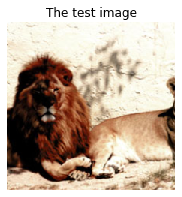

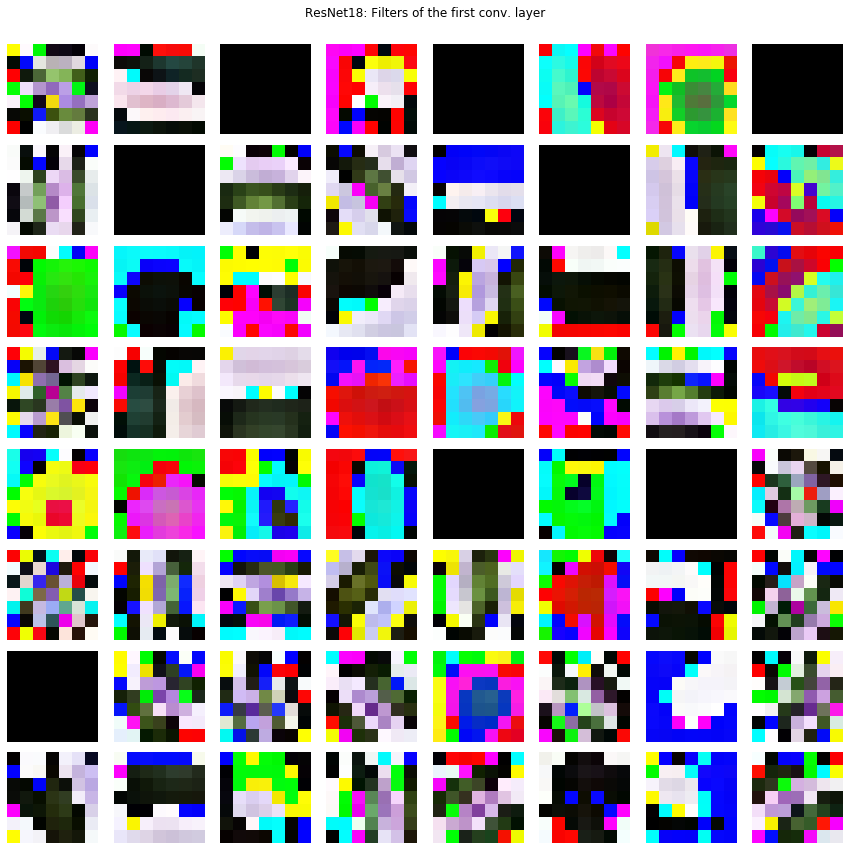

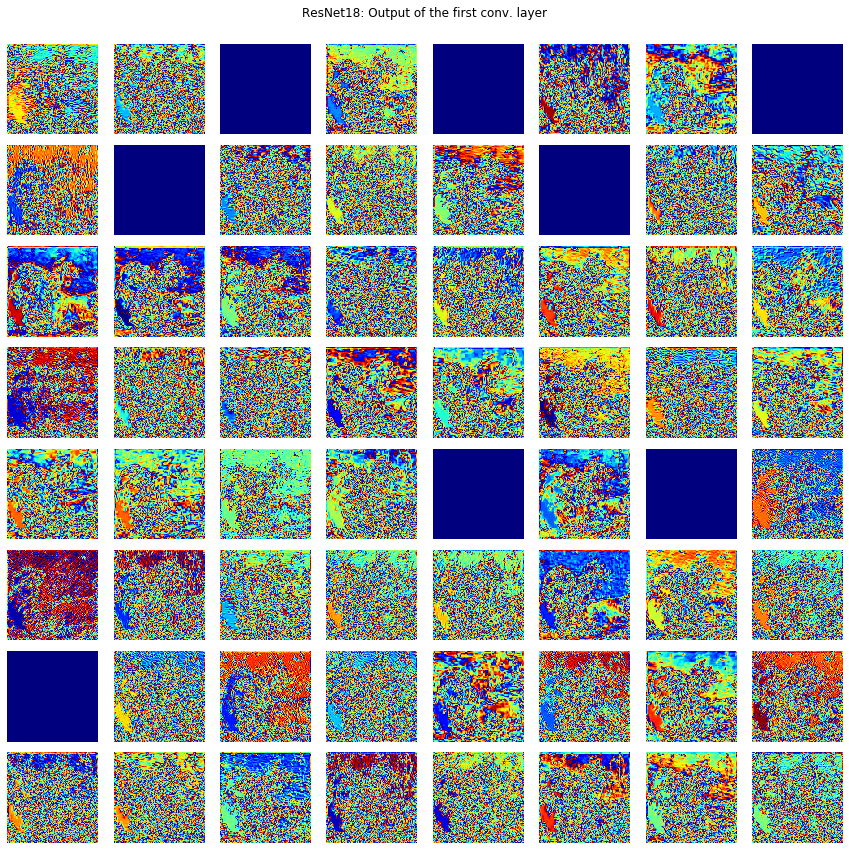

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision.models import resnet18
from torchvision.transforms.functional import to_tensor, to_pil_image, normalize
from PIL import Image
from urllib.request import urlopen

def preprocess_image(image):
    image = to_tensor(image)
    image = normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image.unsqueeze(0)
    return image

def plot_image(ax, image, *args, **kwargs):
    image = image.squeeze(0)
    image = to_pil_image(image)
    ax.set_axis_off()
    ax.imshow(image, *args, **kwargs)


# Download test image
with urlopen('https://seafile.rlp.net/f/c0ff8ca53b5e475aa89b/?dl=1') as f:
    test_img = Image.open(f)
# Preprocess the test image
test_img_pr = preprocess_image(test_img)
print('Test image size:', test_img_pr.shape[-2:])

# Download the model and extract all filters from the first conv. layer
model = resnet18(pretrained=True).eval()
filters = model.conv1.weight
print('Filter Shape:', filters.shape)

# Add a hook to the model that captures the output of the first conv. layer
outputs = {}
def save_output(module, input, output):
    outputs[module] = output.data.clone()
model.conv1.register_forward_hook(save_output)

# Pass the test image through the model and extract the conv. layer output
model(test_img_pr)
conv_results = outputs[model.conv1].squeeze(0)
print('Conv. result shape:', conv_results.shape)

# Plot test image
fig = plt.figure(figsize=(3, 3))
plt.title('The test image')
plt.axis('off')
plt.imshow(test_img)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close(fig)

# Plot filters
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('ResNet18: Filters of the first conv. layer')
for ax, f in zip(axes.flatten(), filters):
    plot_image(ax, f)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close(fig)

# Plot conv. output
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('ResNet18: Output of the first conv. layer')
for ax, img in zip(axes.flatten(), conv_results):
    plot_image(ax, img, cmap=plt.cm.jet)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close(fig)